In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import transforms
from net import *
from utils import *
from loss import *

In [2]:
img_root = "D:/nyc_taxi/data_min_max"
test_imgs = np.load(img_root+'/test.npy')
val_imgs = np.load(img_root+'/val.npy')

### Modeling

In [3]:
## parameters
img_root = "D:/nyc_taxi/data_min_max"
mask_root = "D:/nyc_taxi/data_min_max"
image_size = 64
chunk_size = 5
mape_loss = 0
test_imgs = np.load(img_root+'/test.npy')
test_masks_random = np.load(mask_root+'/test_random_mask.npy')
dataset_test = taxi_data(test_imgs, test_masks_random, image_size, chunk_size)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

## load models
model = PConvUNet(chunk_size=chunk_size)
model.load_state_dict(torch.load(f'../../model_states/chunk_size_{chunk_size}/biased_{mape_loss}'))
model.eval()

### Combination

In [4]:
## param
color = 'Blues'
all_time_max = 1428
num = 2
times = ['2PM', '2AM']
## get test images
indices = [3518, 3530]
_, gt = zip(*[dataset_test[i] for i in indices])
mask, _ = zip(*[dataset_test[i] for i in indices])
mask = torch.stack(mask)
mask[0,:,:,:,:] = torch.zeros_like(mask[0,:,:,:,:])
mask[1,:,:,:,:] = torch.zeros_like(mask[1,:,:,:,:])
mask[0,:,:,0:10, :] = 1
mask[1,:,:,20:, :] = 1
gt = torch.stack(gt)
old_image = mask*gt

gt = torch.sum(old_image, dim=0, keepdim=True)
mask = torch.zeros_like(mask[0].unsqueeze_(0))
mask[:,:,:,0:10, :] = 1
mask[:,:,:,20:, :] = 1
image = mask*gt

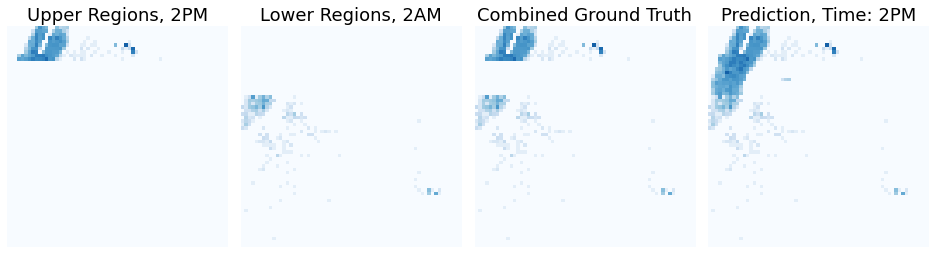

In [5]:
with torch.no_grad():
    output, _ = model(gt, mask)
output_comp = mask * gt + (1 - mask) * output

## scale back + log transformation
gt = torch.log(gt*all_time_max+1) 
image = torch.log(image*all_time_max+1)
old_image = torch.log(old_image*all_time_max+1)
output_comp = torch.log(output_comp*all_time_max+1)

## the last layer
gt = gt[:,:,-1,:,:]
mask = mask[:,:,-1,:,:]
image = image[:,:,-1,:,:]
old_image = old_image[:,:,-1,:,:]
output_comp = output_comp[:,:,-1,:,:]

## visualizations
VMAX=7
fig_size = 16
fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4, figsize=(fig_size,fig_size))
fontsize = 18
ax1.imshow(old_image[0][0],vmin=0, vmax=VMAX,cmap='Blues')
ax1.set_title('Upper Regions, 2PM', size=fontsize)
ax1.axis('off')
ax2.imshow(old_image[1][0],vmin=0, vmax=VMAX,cmap='Blues')
ax2.set_title('Lower Regions, 2AM', size=fontsize)
ax2.axis('off')
ax3.imshow(image[0][0],vmin=0, vmax=VMAX,cmap='Blues')
ax3.set_title('Combined Ground Truth', size=fontsize)
ax3.axis('off')
ax4.imshow(output_comp[0][0],vmin=0, vmax=VMAX,cmap='Blues')
ax4.set_title(f'Prediction, Time: 2PM', size=fontsize)
ax4.axis('off')
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.06, 
                    hspace=-0.63)

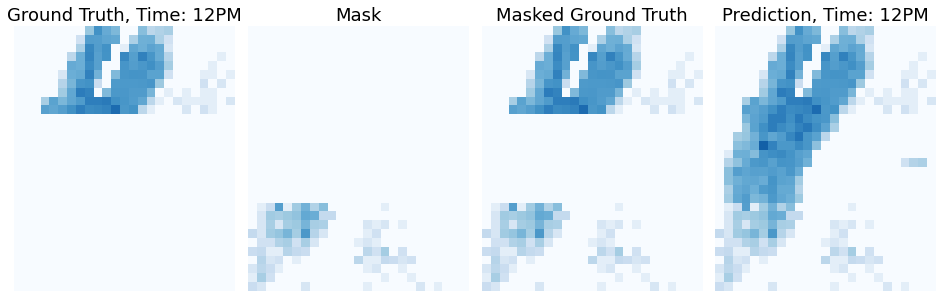

In [15]:
## visualizations
VMAX=7
fig_size = 16
fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4, figsize=(fig_size,fig_size))
fontsize = 18
long_boundary = 25
lat_boundary = 30
ax1.imshow(old_image[0][0][:lat_boundary, :long_boundary],vmin=0, vmax=VMAX,cmap='Blues')
ax1.set_title(f'Ground Truth, Time: 12PM', size=fontsize)
ax1.axis('off')
ax2.imshow(old_image[1][0][:lat_boundary, :long_boundary],vmin=0, vmax=VMAX,cmap='Blues')
ax2.set_title('Mask', size=fontsize)
ax2.axis('off')
ax3.imshow(image[0][0][:lat_boundary, :long_boundary],vmin=0, vmax=VMAX,cmap='Blues')
ax3.set_title('Masked Ground Truth', size=fontsize)
ax3.axis('off')
ax4.imshow(output_comp[0][0][:lat_boundary, :long_boundary],vmin=0, vmax=VMAX,cmap='Blues')
ax4.set_title(f'Prediction, Time: 12PM', size=fontsize)
ax4.axis('off')
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.06, 
                    hspace=-0.5)